In [42]:
#Clear the cache before running
%reset -f

In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import random
sns.set_style('darkgrid')
np.random.seed(1004)

random.seed(58)

import pandas as pd
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter
import os

import warnings
warnings.filterwarnings("ignore")

In [44]:
def stats(df): #the function displays dataframe size, countings of unique patients and unique exams
    print('Dataframe size: ' + str(df.shape))
    try:
        print('# patients: ' + str(df.patient_id.nunique()))
    except:
        print('# patients: ' + str(df.patient_id.nunique()))
    print('# exams: ' + str(df.acc_anon.nunique()))

In [45]:
#----in-control---specificity----
df = pd.read_csv(r"/gpfs_projects/ravi.samala/OUT/2023_MLDrift/20230803-091724__input_list_file_with_output_scores.csv")
#df = pd.read_csv(r"/gpfs_projects/ravi.samala/OUT/2023_MLDrift/20230803-091724__by_patient_scores.csv")

#----out-of-control---specificity----Median Denoised-------
#df_medk10 = pd.read_csv(r"/gpfs_projects/smriti.prathapan/EMBED/OUT/denoised/p6-12k/medk10/20230804-192403__input_list_file_with_output_scores.csv")
#df_medk10 = pd.read_csv(r"/gpfs_projects/smriti.prathapan/EMBED/OUT/denoised/p6-12k/medk10/20230804-192403__by_patient_scores.csv")

#----out-of-control---specificity----Wavelet Denoised--(Bayes, level7)-----
df_wavel7 = pd.read_csv(r"/gpfs_projects/smriti.prathapan/EMBED/OUT/denoised/p6-12k/wavelet-l7-u16/20231017-233737__input_list_file_with_output_scores.csv")
#df_wavel7 = pd.read_csv(r"/gpfs_projects/ravi.samala/OUT/2023_Smriti/OUT/denoised/cancer-list/wavelet-l7-u16/20231020-152417__by_patient_scores.csv")


In [46]:
#Fetch 100 patients per day (day1-60) from df and days 61-120 from df_medk10 which is the out of control region
# compute 

FalsePos         =  np.array([])
TruePos          =  np.array([])
DelaytoDetect    =  np.array([])
FAR              =  np.array([])     #False Alarm Rate
inSTD_test_sp    =  np.array([])     #Standard deviation of test AUCs
outSTD_test_sp   =  np.array([]) 
D                =  np.array([])     #Displacement
h_1000           =  np.array([]) 
k_1000           =  np.array([])
DetectionTimes   =  np.array([],dtype=int)
AvgDD            = np.array([])      # Average Detection Delay
start_in         = 0
end_in           = 30
start_out        = 0
end_out          = 30
sample_size      = 30
#days             = 0
pre_change_days  = 60
post_change_days = 60
total_days       = pre_change_days + post_change_days
patients_in      = df.patient_id.unique()
patients_o       = df_wavel7.patient_id.unique()
sp_pre           = np.array([])
sp_post          = np.array([])
runs             = 0
delta            = 1 #0.616  #0.1481 #0.318

while (runs < 1000):
    days        = 0
    start_in    = 0
    end_in      = 30
    start_out   = 0 
    end_out     = 30
    specificity = np.array([])
    while (days < pre_change_days):
        patients100   = patients_in[start_in:end_in]

        #Fetch all the rows for 100 patients
        p100     = df[df['patient_id'].isin(patients100)]

        #print("Checking stats for 100 patients")
        #stats(p100)
    
        #threshold = 0.31
        threshold_prechange = 0.0177
        FP = p100[p100['preds'] > threshold_prechange]
        TN = p100[p100['preds'] < threshold_prechange]

        #print("Total rows:",      p100.index.size)
        #print("#Below Threshold", TN.index.size)
        #print("#Above Threshold", FP.index.size)
        sp = TN.index.size/p100.index.size
        specificity  = np.append(specificity, sp)
        sp_pre       = np.append(sp_pre, sp)
        
        start_in += sample_size
        end_in   += sample_size
        days     += 1 
    
    while (days < total_days):
        patients100_out   = patients_o[start_out:end_out]

        #Fetch all the rows for 100 patients
        p100_out     = df_wavel7[df_wavel7['patient_id'].isin(patients100_out)]

        #print("Checking stats for 100 patients")
        #stats(p100)
    
        #threshold = 0.31
        #threshold_postchange = 0.0333
        #threshold_postchange = 0.03545
        threshold_postchange = 0.0177
        FP_o = p100_out[p100_out['preds'] > threshold_postchange]
        TN_o = p100_out[p100_out['preds'] < threshold_postchange]

        #print("Total rows:",      p100.index.size)
        #print("#Below Threshold", TN.index.size)
        #print("#Above Threshold", FP.index.size)
        sp_o           = TN_o.index.size/p100_out.index.size
        specificity    = np.append(specificity, sp_o)
        sp_post        = np.append(sp_post, sp_o)
        
        start_out += sample_size
        end_out   += sample_size
        days      += 1
        
    #CUSUM for day0-2000: outcomes are detection delay and #FP, #TP, MTBFA, False alarm rate
    num_rows        = np.shape(specificity)[0]
    in_control_sp   = specificity[:pre_change_days]
    out_control_sp  = specificity[pre_change_days:total_days]
    out_std_sp      = np.std(out_control_sp)
    in_std_sp       = np.std(in_control_sp)
    x               = np.array(specificity)

    mu     = np.mean(in_control_sp)
    mu_1   = np.mean(out_control_sp)
    std    = np.std(in_control_sp)
    std_1  = np.std(out_control_sp)
    displacement = (mu_1-mu)/std
    
    #h      = 0.102       # Upper/lower control limit to detect the changepoint H=0.102, 0.127 
    #k      = 0.03831     # Drift 0.01277 is the 1 sigma change, 0.0255 - one-sigma change, 0.03831 is 3-sigma change, 0.05108
    h      = in_std_sp * 4
    k      = (delta * in_std_sp)/2
   
    # Construct the tabular Chart to record the in-control-STD and h values
    #ControlLimitChart       = np.array([])
    #ControlLimitChart       = np.column_stack((in_std_sp.T, h.T, k.T))
    #df_ControlLimit         = pd.DataFrame(ControlLimitChart)
    #df_ControlLimit.columns = ['std_0','h','k']   
    #filename = "file%d" %runs                                       
    #df_ControlLimit.to_csv(("controlLimits-out/file%d.csv" %runs), sep='\t')
                                        
    
    x_mean = np.zeros(num_rows,dtype=float)
    #S_hi : for positive changes --------------------------
    S_hi = np.zeros(num_rows,dtype=float)
    S_hi[0] = 0.0 # starts with 0
    #Increase in mean = x-mu-k ----------------------------
    mean_hi = np.zeros(num_rows,dtype=float)

    #Decrease in mean = mu-k-x----------------------------
    mean_lo = np.zeros(num_rows,dtype=float)
    #S_lo : for negative changes --------------------------
    S_lo = np.zeros(num_rows,dtype=float)
    S_lo[0] = 0.0 # starts with 0
    #CUSUM: Cumulative sum of x minus mu ------------------
    cusum = np.zeros(num_rows,dtype=float)
    cusum[0] = 0.0 # initialize with 0
    
    for i in range(0, num_rows):
        x_mean[i]  = x[i] - mu  #x_mean 
        mean_hi[i] = x[i] - mu - k
        S_hi[i]    = max(0, S_hi[i-1] + mean_hi[i])
        mean_lo[i] = mu - k - x[i]
        S_lo[i]    = max(0, S_lo[i-1] + mean_lo[i])
        cusum[i]   = cusum[i-1] + x_mean[i]

    x_mean  = np.round(x_mean,decimals=2)
    S_hi    = np.round(S_hi,decimals=2)
    mean_lo = np.round(mean_lo,decimals=2)
    S_lo    = np.round(S_lo,decimals=2)
    cusum   = np.round(cusum,decimals=2)

    # Construct the tabular CUSUM Chart  
    chart = np.array([])
    chart = np.column_stack((x.T, x_mean.T, mean_hi.T, S_hi.T, mean_lo.T, S_lo.T, cusum.T))
    np.round(chart, 2)

    #d = 2 *(np.log((1-0.01) / (0.0027)))
    #h = d * 0.5 # h= d*k where k=0.5
    #h = 4 # as per the NIST doc on CUSUM

    #l1 =  np.append(num_rows, data_tabular, axis = 1)
    #l1 = np.concatenate(num_rows.T, data_tabular.T)
    #chart = np.column_stack((num_rows.T, data_tabular.T))
    #chart

    np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
    #print("CUSUM Chart is:\n", np.round(chart,decimals=2))
    #x_mean

    df_out = pd.DataFrame(chart) 
    df_out.columns = ['X','x-mu','Increase in Mean', 'S_hi', 'Decrease-in-mean', 'S_lo', 'CUSUM']
    #filename = "file%d" %runs
    #df_out.to_csv(("CUSUM-out/file%d.csv" %runs), sep='\t')    
    #print(df.to_string())
    #print(chart)
    #Export datafrae to png
    #import dataframe_image as dfi
    #dfi.export(df,'CUSUM-out/CUSUM-run.png')
    
    
    # False positives and Total alarms
    falsePos = 0
    alarms   = 0
    delay    = 0
    avddd    = 0   # this is the delay from the paper: td-ts (z_k-v) where v is the changepoint and z_k is the time of detection
    #MTBFA    = 0
    
    for i in range(0, num_rows):
        if ((S_hi[i] > h) or (S_lo[i] > h)) and (i<(pre_change_days-1)):   
            #if (i<pre_change_days):
            falsePos += 1  #False Positives 
            #print("time false alarm",i)
            DetectionTimes= np.append(DetectionTimes, i+1)   #time at which a false positive is detected
            #print("detection times",DetectionTimes)
            #print("detection times size",DetectionTimes.size)
            #break

    # Delay to detect the first changepoint
    #delay = 0
    for i in range(0, num_rows):
        if ((S_hi[i] > h) or (S_lo[i] > h)) and (i>(pre_change_days)):
            alarms += 1           #True Positive: break after detecting one TP
            #print("alarm at : ", i)
            #delay  = i-1000+1    # ts is 100 because the change starts at day100
            avddd  = i-pre_change_days
            break
    
    
    #Calculate MTBFA(Mean time time between False Alarms)
    #MTBFA = np.mean(DetectionTimes)
    #FlaseAlarmRate = 1/MTBFA
    
    FalsePos       = np.append(FalsePos, falsePos)
    TruePos        = np.append(TruePos, alarms)
    #DelaytoDetect = np.append(DelaytoDetect, delay)   # td-ts+1
    #FAR           = np.append(FAR, FlaseAlarmRate)
    #DetectionTimes= np.append(DetectionTimes, detectionTime)
    AvgDD          = np.append(AvgDD, avddd)   # ADD estimate from the paper
    outSTD_test_sp = np.append(outSTD_test_sp, out_std_sp)
    inSTD_test_sp  = np.append(inSTD_test_sp, in_std_sp)
    D              = np.append(D, displacement)
    h_1000         = np.append(h_1000, h)
    k_1000         = np.append(k_1000, k)
    #print(falsePos)    
    
        
    #Shuffle the patient list for the next simulation
    random.shuffle(patients_in)
    random.shuffle(patients_o)
    runs      += 1  # continue until end of simulation

In [47]:
#specificity
print("H is ",h)
print("Drift is", k)
print("total number of False Positives:",np.sum(FalsePos))
print("Total True Positives:",np.sum(TruePos))
print("Total False Negatives:",runs-np.sum(TruePos))
print("Average Detection Delay",np.mean(AvgDD))
print("Minimum Delay",np.min(AvgDD))
print("Maximum Delay",np.max(AvgDD))
MTBFA = np.mean(DetectionTimes)
FlaseAlarmRate = 1/MTBFA
print("MTBFA", MTBFA)
print("Flase Alarm Rate", FlaseAlarmRate)
nonZeroAvgDD = AvgDD[np.nonzero(AvgDD)]  
print("Mean ref. Value", np.mean(k_1000))   
print("Mean STD_0", np.mean(inSTD_test_sp)) 
print("Mean STD_1", np.mean(outSTD_test_sp)) 
print ("mu_0", mu)
print ("mu_1", mu_1)
print ("std_0", std)
print("Displacement, d:",(mu_1-mu)/std)
print("Mean Displacement:", np.mean(D))

H is  0.16529428108443117
Drift is 0.020661785135553896
total number of False Positives: 473.0
Total True Positives: 1000.0
Total False Negatives: 0.0
Average Detection Delay 4.151
Minimum Delay 1.0
Maximum Delay 18.0
MTBFA 34.084566596194506
Flase Alarm Rate 0.029338791713186946
Mean ref. Value 0.02329685662236008
Mean STD_0 0.04659371324472016
Mean STD_1 0.05356682576218047
mu_0 0.8422776848436432
mu_1 0.7812545185194003
std_0 0.04132357027110779
Displacement, d: -1.476715732060268
Mean Displacement: -1.3373665890391624


In [11]:
mu     
mu_1  
std   
std_1  
d = (mu_1 - mu)/std
d

1.263648446372366

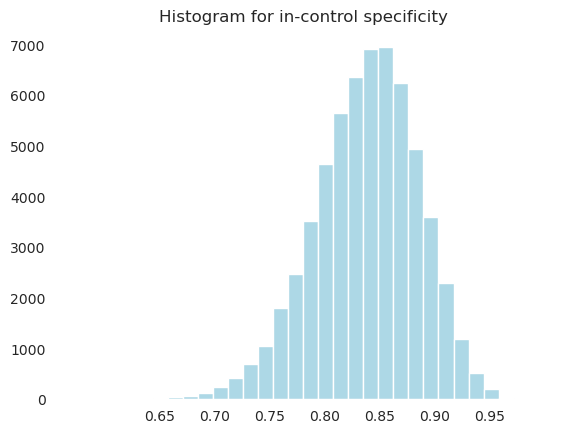

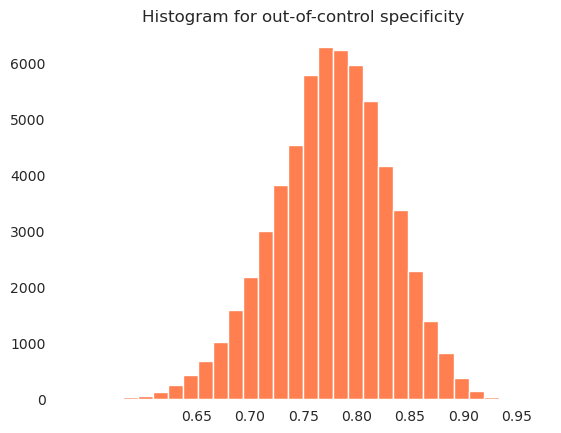

In [49]:
# PLOT THE HISTOGRAM OF Specificities - all the specificities for 1000 simulations * 100 days (60 samples per day)

#Display the histogram of in-control AUC, along with the probability density function
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(sp_pre, 30, color = "lightblue")
#plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu)**2 / (2 * std**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
#plt.xticks([0.725, 0.750, 0.775, 0.800, 0.825, 0.850, 0.875, 0.900, 0.925, 0.950])
plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
plt.title('Histogram for in-control specificity')
plt.show()

#Display the histogram of out-of-control AUC, along with the probability density function
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(sp_post, 30, color = "coral")
#plt.plot(bins, 1/(std_1 * np.sqrt(2 * np.pi)) *
#               np.exp( - (bins - mu_1)**2 / (2 * std_1**2) ),
#         linewidth=2, color='r')
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(visible=None)
#plt.xticks([0.725, 0.750, 0.775, 0.800, 0.825, 0.850, 0.875, 0.900, 0.925, 0.950])
plt.xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])
plt.title('Histogram for out-of-control specificity')
plt.show()

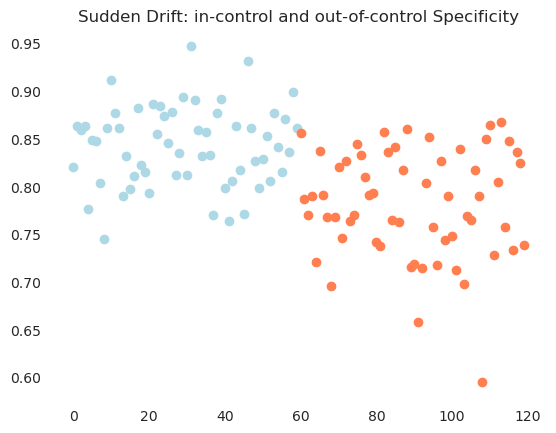

In [50]:
#Plot the specificity
#pre_change_days  = 60
#post_change_days = 60
total_days       = pre_change_days + post_change_days
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(b=None)
y1 = np.arange(pre_change_days)
x1 = specificity[:pre_change_days]
plt.scatter(y1, x1, c='lightblue')
y2 = np.arange(pre_change_days, total_days, 1)
x2 = specificity[pre_change_days:total_days]  #prev
#x2 = specificity_medk10[:pre_change_days]
plt.scatter(y2, x2, c='coral')
#plt.hlines(y = mu, xmin=0, xmax=pre_change_days,color = 'lightblue', linestyle = '--')
#plt.hlines(y = mu1, xmin=pre_change_days, xmax=total_days,color = 'coral', linestyle = '--')
# single vline with specific ymin and ymax
#plt.vlines(x=pre_change_days, ymin=mu1, ymax=mu, colors='lightgrey', linestyle = '--')
#yline(0.86)
#plt.plot(test_AUC, 'go')


plt.title('Sudden Drift: in-control and out-of-control Specificity')
plt.show()

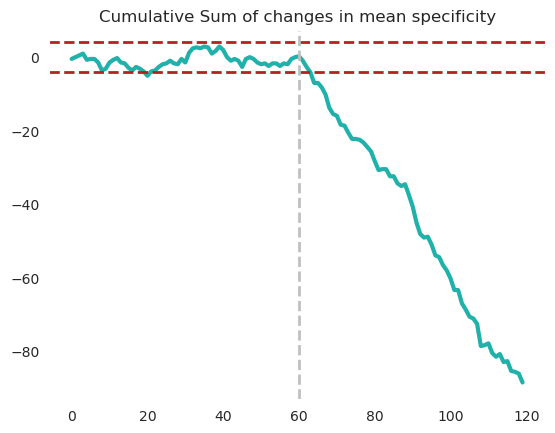

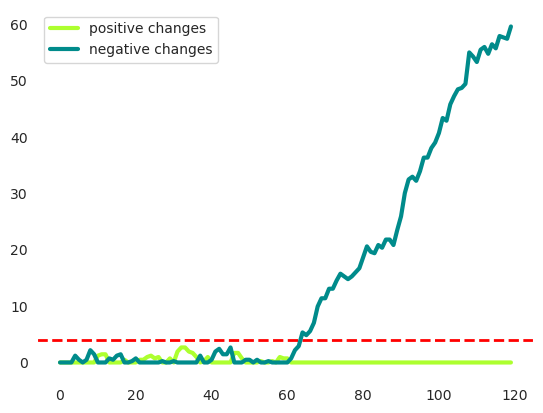

In [72]:
#CUSUM
#plt.plot(cusum/std, '#1F77b4',linewidth=3.0) #blue line
plt.plot(cusum/std, 'lightseagreen',linewidth=3.0)
plt.axhline(y = h/std, color = 'firebrick', linestyle = '--', linewidth=2.0)  # dark red line
plt.axhline(y = -h/std, color = 'firebrick', linestyle = '--', linewidth=2.0) # dark red line
#plt.axhline(y = h/std, color = '#d62728', linestyle = '--', linewidth=2.0)  #red line
#plt.axhline(y = -h/std, color = '#d62728', linestyle = '--', linewidth=2.0) # red line
#plt.axhline(y = h/std, color = '#2ca02c', linestyle = '--', linewidth=2.0)   #green line
#plt.axhline(y = -h/std, color = '#2ca02c', linestyle = '--', linewidth=2.0)  #green line
plt.axvline(x = 60, color = 'silver', linestyle = '--', linewidth=2.0)
#plt.axvline(x = 60, color = 'k', linestyle = '--', linewidth=2.0) # black line
plt.title('Cumulative Sum of changes in mean specificity')
plt.show()

# specifying horizontal line type
#plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100])
plt.axhline(y = h/std, color = 'red', linestyle = '--', linewidth=2.0)
plt.plot(S_hi/std,  'greenyellow', label='positive changes',linewidth=3.0)
plt.plot(S_lo/std, 'darkcyan', label='negative changes', linewidth=3.0)
#plt.title('Positive and Negative Changes')
#plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50, 55, 60])
#plt.yticks([0, 5, 10, 15, 20, 25])
#plt.yticks([0, 10, 20, 30, 40, 50, 60])
plt.legend()
plt.show()